# Conformal Quantile Regression for the Conditional Average Treatment Effect

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({"font.size": 8})

Conformal prediction is not just about providing a prediction but also about quantifying the confidence we can place in that prediction. Instead of offering a single output, it generates a prediction set that likely contains the true output. This set is derived from a validity property which ensures that, given a certain confidence level, the true output is included in the prediction set with a corresponding probability [1].

Já discutimos no post sobre [Conditional Density Estimation](https://vitaliset.github.io/conditional-density-estimation/), como dar uma noção de confiança associada a sua previsão é importante e não seria diferente em aplicações de inferência causal em que estimar intervalos de confiança para o Conditional Average Treatment Effect (CATE) can greatly enhance the validity of causal inference studies.

In the binary treatment $T\in\{0, 1\}$ scenario, CATE is defined as the expected difference in outcomes $Y$ when an individual with certain observable characteristics is treated versus when the same individual is not treated. Mathematically, it can be expressed as the difference in expected potential outcomes conditional on the same covariates $Z$ [2, 3, 4].

Dependendo da escola de inferência causal que você vem, podemos escrever [2]

$$ \textrm{CATE}_{T, Y}(z) = \mathbb{E}(Y| do(T=1), Z=z) - \mathbb{E}(Y| do(T=0), Z) = \mathbb{E}(Y_1 | Z=z) - \mathbb{E}(Y_0 | Z=z).$$

CATE helps estimate the effect of a treatment on an individual level, taking into account the specific characteristics of each individual. This is incredibly valuable in many fields of industry where understanding the effect of a "treatment" (such as a sale) on different subpopulations helps in creating personalized treatment plans depending on the desired outcome (for instance retention).

## Pequena revisão de controle de confudidores

É comum utilizar como variáveis da condicional do CATE um conjunto que satisfaça o critério backdoor para medir o efeito causal de $T$ em $Y$ (ou, na teoria do Rubin, que faz X ficar condicionalmente ignorável para medir o efeito causal em $Y$). Isso é importante porque, nesse cenário, $Z$ controla confudidores [2], e daí

$$f(z|do(T=t)) = f(z)\textrm{, and }f(y|do(T=t), Z=z) = f(y|T=t, Z=z),$$

sendo possível demonstrar que

$$\mathbb{E}[Y|do(T=t), Z] = \mathbb{E}[Y|T=t, Z=z].$$

Essa relação é importante pois nos permite estimar essa quantidade com algum modelo supervisionado qualquer de aprendizado de máquina. Essa técnica é conhecida como fórmula do ajuste e tem várias sabores diferentes como os meta-learners e a técnica de matching.

Apesar de útil, a aplicação de conformal prediction para estimativa do CATE no cenário proposto acima não é trivial. Como o CATE binário envolve a estimativa de duas quantidades, é necessário combinar os intervalos de previsão dessas duas estimativas de alguma forma. Vamos discutir como podemos fazer isso sem nenhuma suposição paramétrica.

$\oint$ Para cenários de tratamento contínuo, a minha experiência tem mostrado que $\mathbb{E}(Y| do(T=1), Z=z)$ nos dá mais informação que o CATE (que é definido como a derivada dessa esperaça). Aqui é um pouco mais fácil de usar diretamente a conformal prediction pois esse cenário pode ser interpretado apenas como uma regressão, quando se usa a fórmula do ajuste. Para fazer estimações intervalares para essas quantidades, estratégias de bootstrap da estimação parecem uma estratégia mais direta apesar de custosa. Se você tem alguma ideia melhor, adoraria ouvir! :D

## Creating the dataset

Para exemplificar a nossa aplicação, vamos utilizar um grafo causal simples em que $Z$ será um confudidor que servirá de conjunto que satisfaz o critério backdoor.

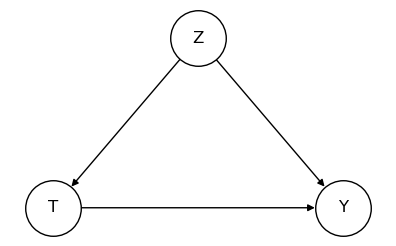

In [2]:
import networkx as nx

fig, ax = plt.subplots(figsize=(4, 2.5))
G = nx.DiGraph()
G.add_edges_from(
    [
        ("Z", "T"),
        ("Z", "Y"),
        ("T", "Y"),
    ]
)

pos = {
    'T': [-1, 0],
    'Z': [0, 0.6],
    'Y': [1, 0]
}
nx.draw_networkx(G, pos, node_size=1600, node_color="w", edgecolors="k", with_labels=True, arrows=True, ax=ax)
ax.set_xlim(-1.3, 1.3)
ax.axis('off')
ax.set_ylim(-0.1, 0.7)
plt.tight_layout()


Com grafo causal estrutural dado por:

$$U_Z \sim \textrm{Uniform}(-\pi, \pi)\textrm{, with }g_Z(u_Z) = u_Z,$$

$$U_T \sim \textrm{Uniform}(0, 1)\textrm{, with }$$
$$g_Z(u_T, z) = \mathbb{1}(u_T \leq 0.05 + 0.9\, \sigma(3z))\textrm{, where }\sigma(x) = \frac{1}{1 + \exp(-x)},$$

$$U_Y \sim \mathcal{N}(0, 1)\textrm{, with }$$
$$g_Y(u_Y, z, t) = \mathbb{1}(t=0) (10 \sin(z)) + \mathbb{1}(t=1) (10 \cos(z)) + 0.5 (1 + |z|)\,u_y.$$

Repare que estamos num cenário razoável de aplicar inferência causal uma vez que é garantida a hipótese de positividade [5], ou seja, vale que

$$ 0 < \mathbb{P}(T=t | Z=z) < 1 \textrm{, }\forall t \in \textrm{Im}(T)= \{ 0, 1\}, z \in \textrm{Im}(Z) = (0, 1).$$

In [3]:
def adapted_sigmoid(x):
    return 0.05 + 0.9 / (1 + np.exp(- x))

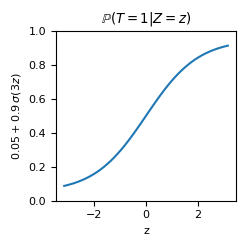

In [4]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.plot(np.linspace(- np.pi, np.pi), adapted_sigmoid(np.linspace(-np.pi, np.pi)))
ax.set_ylim(0, 1)
ax.set_title("$\mathbb{P}(T=1 | Z=z)$")
ax.set_xlabel("z")
ax.set_ylabel("$0.05 + 0.9 \,\sigma(3z)$")
plt.tight_layout()

In [5]:
def func_0(Z):
    return 10 * np.sin(Z)

def func_1(Z):
    return 10 * np.cos(Z)

def generate_data(size=100, obs=True, random_state=None):
    rs = np.random.RandomState(random_state).randint(
        0, 2**32 - 1, dtype=np.int64, size=4
    )
    
    Z_obs = np.random.RandomState(rs[0]).uniform(low=- np.pi, high=np.pi, size=size)
    
    def g_T_noised(Z):
        return np.random.RandomState(rs[1]).binomial(n=1, p=adapted_sigmoid(Z)).astype(bool)

    T_obs = g_T_noised(Z_obs)

    noise = np.random.RandomState(rs[3]).normal(size=size)

    def g_Y(T, Z, noise):
        return np.select(condlist=[T], choicelist=[func_1(Z)], default=func_0(Z)) + 0.5 * (1 + np.abs(Z)) * noise

    Y_obs = g_Y(T_obs, Z_obs, noise)
    Y_cf = g_Y(~T_obs, Z_obs, noise)
    
    def generate_df(T, Z, Y):
        return pd.DataFrame(np.vstack([T.astype(int), Z, Y]).T, columns=["treatment", "confounder", "target"])
    
    df_obs = generate_df(T_obs, Z_obs, Y_obs)
    df_cf = generate_df(~T_obs, Z_obs, Y_cf)
    
    return df_obs, df_cf

df_obs, df_cf = generate_data(size=50_000, obs=True, random_state=42)

Como estamos num cenário de dados sintéticos conseguimos observar tanto o cenário observacional, quanto o cenário contrafactual. Nesse caso, conseguimos de fato obter $Y_1 - Y_0$ para cada exempo. Assim, vamos poder avaliar nossas estimativas utilizando um conjunto de teste separado do conjunto de treino, como num cenário supervisionado usual.

In [6]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(
    df_obs.assign(target_cf=df_cf.target),
    test_size=0.2,
    random_state=42,
)

df_train_t0 = df_train.query("treatment == 0")
df_train_t1 = df_train.query("treatment == 1")

def return_XZ_y(df, backdoor_set_list):
    return df.filter(backdoor_set_list), np.array(df.target)

backdoor_set = ["confounder"]

XZ_train_t0, y_train_t0 = return_XZ_y(df_train_t0, backdoor_set)
XZ_train_t1, y_train_t1 = return_XZ_y(df_train_t1, backdoor_set)

XZ_test, y_test = return_XZ_y(df_test, backdoor_set)

## Positivy Assumption

Uma assumption que fica mascarada na teoria do Pearl, mas que precisa sempre ser testada é a Positivy Assumption. Vimos anteriomente que, nos nossos dados sintéticos, ela está satisfeita, mas num cenário na vida real, isso precisaria ser minimamente validado.

$\oint$ Se você está num cenário onde há uma parcela da sua população que sempre é randomizada, então isso é garantido. Isso é uma das impotâncias de se ter um processo de experimentação contínua num produto baseado em inferência causal.

A importância de a Positivy Assumption ser satisfeita é imediata: como prever o que acontece com $Y$ quando $T$ tem um determinado valor em regiões de $Z$ que nao tem ninguem com tal tratamento? Naturalmente, o problema fica impossível, ou sua aproximação fica muito grosseira porque usa exemplos distantes para fazer as previsões para aquele ponto.

A maneira usual de tentar garantir isso é utilizando algum modelo para tentar estimar $T$ utilizando $Z$ e avaliar ele. Se esse modelo tiver uma performance muito alta, isso significa que a relação é provavelmente determinística e que a positivy assumption é violado. No caso de tratamento binário, que é o nosso caso, podemos avaliar um modelo que seja razoavelmente bem calibrado (ou calibrar o modelo de fato [6]) e estudar como está a distribuição das probabilidades.

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

positivy_assumption_check_estimator =  LogisticRegression(
    random_state=42,
).fit(df_train.drop(columns=["treatment", "target", "target_cf"]), df_train.treatment)

roc_auc_score(df_test.treatment, positivy_assumption_check_estimator.predict_proba(XZ_test)[:, 1])

0.8370462957096292

A [`sklearn.metrics.roc_auc_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html) já nos indica que estamos num cenário razoável de assumir a Positivy Assumption. Quando existem regiões determinísticas para a relação de $T$ e $Z$ isso costuma indicar uma [`sklearn.metrics.roc_auc_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html) próxima de 1.

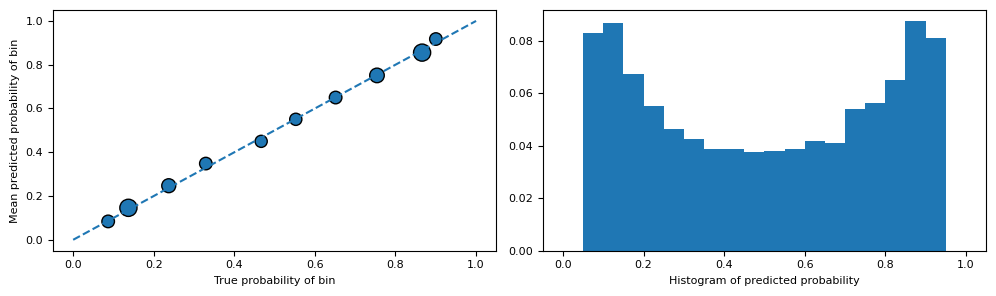

In [8]:
from cal import calibration_curve

probs = positivy_assumption_check_estimator.predict_proba(XZ_test)[:, 1]
prob_true, prob_pred, size_bin = calibration_curve(df_test.treatment, probs, n_bins=10)

fig, ax = plt.subplots(ncols=2, figsize=(10, 3))
ax[0].plot([0, 1], "--")
ax[0].scatter(prob_true, prob_pred, s=(0.1 * size_bin).astype(int), edgecolor="k")
ax[0].set_xlabel("True probability of bin")
ax[0].set_ylabel("Mean predicted probability of bin")
ax[1].hist(probs, bins=np.linspace(0, 1, 21), weights=np.ones_like(probs)/probs.shape[0])
ax[1].set_xlabel("Histogram of predicted probability")
plt.tight_layout()

De fato, após verificar que o modelo está razoavelmente calibrado, é possível observar que os histogramas de probabilidade não tem exemplos com probabilidade próximas de 0 ou de 1. Indicando que estamos num cenário razoável para estimar o CATE.

$\oint$ O cenário de tratamento contínuo é um pouco mais tricky, mas avaliar métricas de regressão dão uma boa intuição dessa relação. Outra técnica razoável é discretizar o tratamento e analizar essa estimar essas probabilidades de forma análoga ao feito para o caso binário.

## Conformalized Quantile Regression

A regressão quantílica com pinball loss [7] é uma maneira razoável de tentar prever quantis condicionais de uma variável target. Entretanto, essas estimativas $Q_{\beta}$ e $Q_{1-\beta}$ dos quantis condicionais $\beta \in (0, 1)$ e $1 - \beta$, respectivamente, não satisfazem a propriedade de cobertura que exige que $\mathbb{P}((Y|Z=z) \in (Q_{\beta}$ e $Q_{1-\beta})) \geq 1 - 2 \beta$ [8].

Conformalized Quantile Regression utiliza a regressão quantílica anterior com uma correção nessas previsões de quantis condicionais de forma que garatimos a cobertura marginal [1, 8].

Podemos implementar, seguindo os padrões do scikit-learn, uma versão de Conformalized Quantile Regression fazendo exatamente a estratégia anterior.

In [9]:
from sklearn.base import BaseEstimator
from sklearn.utils.validation import check_X_y, check_is_fitted, _check_sample_weight
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV, KFold

from lightgbm import LGBMRegressor

from statsmodels.stats.weightstats import DescrStatsW
from scipy.stats import loguniform
from functools import partial

class ConformalizedQuantileRegression(BaseEstimator):
    def __init__(self, alpha=0.05, calibration_size=0.2, random_state=None, n_iter_cv=10):
        self.alpha = alpha
        self.calibration_size = calibration_size
        self.random_state = random_state
        self.n_iter_cv = n_iter_cv
    
    def _quantile_loss(self, y_true, y_pred, quantile=None, sample_weights=None):
        weighted_errors = (y_true - y_pred) * (quantile - (y_true < y_pred))
        if sample_weights is not None:
            weighted_errors *= sample_weights
        return np.mean(weighted_errors)
    
    def _return_quantile_model(self, quantile):    
        quantile_scorer = make_scorer(partial(self._quantile_loss, quantile=quantile), greater_is_better=False)
        
        return RandomizedSearchCV(
            estimator=LGBMRegressor(random_state=self.random_state, objective='quantile', alpha=quantile),
            cv=KFold(shuffle=True, random_state=self.random_state),
            param_distributions={
                "learning_rate": loguniform.rvs(random_state=self.random_state, a=0.0001, b=1, size=1000),
                "n_estimators": [50, 100, 200],
                "num_leaves": [31, 63, 127],
            },
            scoring=quantile_scorer,
            n_iter=self.n_iter_cv,
            random_state=self.random_state,
            n_jobs=-1,
        )
    
    def fit(self, X, y, sample_weight=None):
        X, y = check_X_y(X, y)
        sample_weight = _check_sample_weight(sample_weight, X)
        
        X_train, X_cal, y_train, y_cal, sample_weight_train, sample_weight_cal = train_test_split(
            X, y, sample_weight, test_size=self.calibration_size, random_state=self.random_state)
        
        self.model_lower_ = self._return_quantile_model(quantile=self.alpha/2).fit(X_train, y_train, sample_weight=sample_weight_train)
        self.model_upper_ = self._return_quantile_model(quantile=1 - self.alpha/2).fit(X_train, y_train, sample_weight=sample_weight_train)
        
        self.y_cal_conformity_scores_ = np.maximum(
            self.model_lower_.predict(X_cal) - y_cal, 
            y_cal - self.model_upper_.predict(X_cal))
        wq = DescrStatsW(data=self.y_cal_conformity_scores_, weights=sample_weight_cal)
        self.quantile_conformity_scores_ = wq.quantile(probs=1 - self.alpha, return_pandas=False)[0]
        
        return self

    def predict(self, X):
        check_is_fitted(self)
        y_test_interval_pred_cqr = np.column_stack(
            [self.model_lower_.predict(X) - self.quantile_conformity_scores_,
             self.model_upper_.predict(X) + self.quantile_conformity_scores_])
        return y_test_interval_pred_cqr

## Treinando os estimadores de $\mathbb{E}[Y|do(T=t), Z]$

Com esse estimador conforme construído, podemos utilizar qualquer técnica desejada para estimar $\mathbb{E}[Y|do(T=t), Z]$ e consequemente o $\textrm{CATE}$.

Nesse exemplo, vamos utilizar a técnica do T-learner [10], construindo um modelo para estimativa de cada $\mathbb{E}[Y|do(T=t), Z]$. Vamos utilizar `alpha=0.05` para construir predictions sets com covarage de 95%. 

In [10]:
model_t0 = (
    ConformalizedQuantileRegression(random_state=42, alpha=0.05, n_iter_cv=30)
    .fit(XZ_train_t0, y_train_t0)
)
y_test_interval_pred_cqr_t0 = model_t0.predict(XZ_test)

model_t1 = (
    ConformalizedQuantileRegression(random_state=42, alpha=0.05, n_iter_cv=30)
    .fit(XZ_train_t1, y_train_t1)
)
y_test_interval_pred_cqr_t1 = model_t1.predict(XZ_test)

$\oint$ _Note that you may want to do a importance_weighting strategy here to get a better prediction set at regions where $P(T=t | Z=z)$ is close to zero (naturalmente, sendo regiões com meno exemplos). But if you can garantee the Positivity Assumption, it may be less important (especially with models that dont underfit such as tree ensembles [9])._

_Para fazer isso, você pode fazer algo como_

In [11]:
def return_sample_weight_treatment_i(df_train, df_test):
    df_ood_ti = pd.concat(
        [df.assign(train_or_test=j) for j, df in enumerate([
            df_train.drop(columns=["treatment", "target_cf"]),
            df_test.drop(columns=["treatment", "target_cf"]),
        ])]
    )
    
    ood_sample_correction_ti = LogisticRegression(
        random_state=42,
    ).fit(df_ood_ti.drop(columns=["train_or_test"]),
          df_ood_ti.train_or_test)

    roc = roc_auc_score(df_ood_ti.train_or_test,
                        ood_sample_correction_ti.predict_proba(df_ood_ti.drop(columns=["train_or_test"]))[:, 1])
    
    probs = ood_sample_correction_ti.predict_proba(df_train.drop(columns=["treatment", "target_cf"]))
    # Equivalent to `probs[:, 1]/probs[:, 0]`.
    sample_weights_ti = 1/probs[:, 0] - 1

    return roc, sample_weights_ti

_, sw_0 = return_sample_weight_treatment_i(df_train=df_train_t0, df_test=df_test)

## Avaliando a regressão conforme

Com as estimativas intervalares calculadas em `y_test_interval_pred_cqr_t0` e `y_test_interval_pred_cqr_t1` podemos verificar se estamos fazendo um bom trabalho nas nossas previsões. Para isso, vamos analisar algumas coisas como a cobertura das nossas previsõe, tanto no cenário observacional quanto no cenário contrafactual, já que temos esse valor também para avaliar, e o tamanho desses intervalos.

In [12]:
df_val = (
    df_test
    .assign(pred_lower_t_0=y_test_interval_pred_cqr_t0[:, 0])
    .assign(pred_upper_t_0=y_test_interval_pred_cqr_t0[:, 1])
    .assign(ic_size_t_0=lambda df_: df_.pred_upper_t_0 - df_.pred_lower_t_0)
    .assign(pred_lower_t_1=y_test_interval_pred_cqr_t1[:, 0])
    .assign(pred_upper_t_1=y_test_interval_pred_cqr_t1[:, 1])
    .assign(ic_size_t_1=lambda df_: df_.pred_upper_t_1 - df_.pred_lower_t_1)
    .assign(prob=lambda df_: positivy_assumption_check_estimator.predict_proba(df_.filter(backdoor_set))[:, 1])
    .assign(prob_cut=lambda df_: pd.cut(df_.prob, bins=np.linspace(0, 1, 6)))
    .assign(coverage=lambda df_:
            np.select(condlist=[df_.treatment == 0],
                      choicelist=[(df_.target > df_.pred_lower_t_0) & (df_.target < df_.pred_upper_t_0)],
                      default=(df_.target > df_.pred_lower_t_1) & (df_.target < df_.pred_upper_t_1)))
    .assign(coverage_cf=lambda df_:
            np.select(condlist=[df_.treatment != 0],
                      choicelist=[(df_.target_cf > df_.pred_lower_t_0) & (df_.target_cf < df_.pred_upper_t_0)],
                      default=(df_.target_cf > df_.pred_lower_t_1) & (df_.target_cf < df_.pred_upper_t_1)))
)

df_val.coverage.mean()

0.9485

É importante reparar que, a previsão conforme nos garante uma cobertura marginal que nem sempre se traduz em cobertura condicional [1]. Poderíamos estar construindo estimativas muito boas para algumas regiões de $Z$ e outras ruins para o restante. Para analisar isso precisaríamos estudar

$$P((Y|Z=z)\in \tau(Z=z) | T=t, Z=z).$$

Uma forma de tentar ver isso é quebrando, por exemplo, pelas regiões delimitadas por $P(T=1 | Z=z)$ que construímos para verificar a Positivy Assumption além do próprio tratamento. Nessas subpopulações podemos calcular estimativas para o covarage e ver se estamos batendo o desejado.

Com `scipy.stats.bootstrap` podemos estimar intervalos de confiança para o nosso coverage.

In [13]:
from scipy.stats import bootstrap
def bootstrap_ci(x, ci=0.95):
    boot = bootstrap((x,), np.mean, confidence_level=ci)
    return np.round(boot.confidence_interval, 5)

df_val_cond_aux1 = (
    df_val
    .groupby(["prob_cut", "treatment"])
    .coverage
    .apply(bootstrap_ci)
    .to_frame()
    .rename(columns={"coverage": "coverage_confidence_interval"})
)

df_val_cond_aux2 = (
    df_val
    .groupby(["prob_cut", "treatment"])
    .coverage_cf
    .apply(bootstrap_ci)
    .to_frame()
    .rename(columns={"coverage_cf": "coverage_cf_confidence_interval"})
)

df_val_cond_aux3 = (
    df_val
    .groupby(["prob_cut", "treatment"])
    .agg({"coverage": np.mean, "coverage_cf": np.mean, "ic_size_t_0": np.mean, "ic_size_t_1": np.mean})
    .rename(columns=lambda col: col + "_mean")
)

pd.concat([df_val_cond_aux1, df_val_cond_aux2, df_val_cond_aux3], axis=1).reset_index().sort_values(["treatment", "prob_cut"])

,prob_cut,treatment,coverage_confidence_interval,coverage_cf_confidence_interval,coverage_mean,coverage_cf_mean,ic_size_t_0_mean,ic_size_t_1_mean
0,"(0.0, 0.2]",0.0,"[0.93381, 0.95348]","[0.93094, 0.95108]",0.943885,0.941487,6.663791,6.920811
2,"(0.2, 0.4]",0.0,"[0.94474, 0.96669]","[0.93565, 0.95988]",0.956851,0.948524,4.299289,4.205569
4,"(0.4, 0.6]",0.0,"[0.93891, 0.96946]","[0.94024, 0.96946]",0.956175,0.956175,2.610150,2.642784
6,"(0.6, 0.8]",0.0,"[0.92143, 0.96071]","[0.94464, 0.97679]",0.942857,0.962500,3.923846,4.066495
8,"(0.8, 1.0]",0.0,"[0.91579, 0.96842]","[0.92982, 0.97895]",0.947368,0.957895,6.838792,6.671260
1,"(0.0, 0.2]",1.0,"[0.90813, 0.96466]","[0.91519, 0.9682]",0.939929,0.946996,6.450266,6.573730
3,"(0.2, 0.4]",1.0,"[0.8998, 0.94695]","[0.92141, 0.96071]",0.925344,0.943026,4.162456,4.025180
5,"(0.4, 0.6]",1.0,"[0.93231, 0.96296]","[0.93359, 0.96424]",0.948914,0.950192,2.605642,2.636064
7,"(0.6, 0.8]",1.0,"[0.94092, 0.96353]","[0.93508, 0.95915]",0.953319,0.948213,4.136597,4.291990
9,"(0.8, 1.0]",1.0,"[0.94, 0.95902]","[0.94195, 0.96098]",0.950244,0.952195,7.128496,6.862401


De fato, parece que estamos fazendo um trabalho razoável também na nossa cobertura condicional, bem próxima de 95%, covarage pedido do `ConformalizedQuantileRegression`. Isso significa que, mesmo em regiões com menos exemplos com tratamento $T=0$ (como por exemplo, com `prob_cut=[0.8, 1)`), temos um covarage razoável.

$\oint$ _Como $P((Y|Z=z)\in \tau(Z=z) | T=t, Z=z)$ tem muita cara de um problema de classificação, uma outra estratégia razoável pode ser estudar como seria o output probabilístico de um classificador que tem prever esse problema._

In [14]:
probs_covarege = (
    LogisticRegression()
    .fit(
        df_val.filter(["treatment", "confounder"]),
        df_val.coverage.astype(int))
    .predict_proba(
        df_val.filter(["treatment", "confounder"])
    )[:, 1]
)

roc_auc_score(df_val.coverage.astype(int), probs_covarege)

0.5186764999411436

_Fazendo isso de forma rápida, podemos ver que o classificador não consegue identificar regiões onde há um covarege ruim. Podemos ver que mínimo dessas probabilidades condicionais estimadas (sem muita verificação da calibração) ainda sim é razoavelmente alto._

In [15]:
min(probs_covarege), max(probs_covarege)

(0.9388741811967309, 0.9568780756494982)

$\oint$ É comum também avaliar a cobertura condicional ao tamanho do intervalo previsto (quebrando em algums quantis também como pequeno, médio e grande) [1]. Em uma aplicação real, eu faria isso, mas não quero deixar esse texto com códigos muito longos, então o de cima já ilustra o exercício.

## Unindo os intervalos

Apesar das estimativas estarem parecendo coerentes, o que queremos realmente estimar no final é o que acontece quando tiramos a diferença dos intervalos previstos. Unir intervalos mantendo o covarege não é uma tarefa imediata. Vamos discutir um pouco sobre esse cenário.

Suponha que $$\mathbb{P}(A \in (m_a, M_a)) \geq 1 - \alpha, \mathbb{P}(B \in (m_b, M_b)) \geq 1 - \beta.$$

Repare que a intersecção desses dois eventos implica que a soma está no intervalo dado pela soma das extremidades dos intervalos, ou seja
$$\{A \in (m_a, M_a)\} \cap \{ B \in (m_b, M_b)\} \subset  \{A + B \in (m_a + m_b, M_a + M_b)\}.$$

Pelas regras de probabilidade, o conjunto contido no outro fica limitado pela probabilidade do maior, portanto
$$\mathbb{P}(\{A \in (m_a, M_a)\} \cap \{ B \in (m_b, M_b)\}) \leq \mathbb{P}(\{A + B \in (m_a + m_b, M_a + M_b)\}).$$

Vamos fazer uma inequação a partir do termo esquerdo dessa desigualdade. Podemos calcular a probabilidade do complementar como
$$ \mathbb{P}(\left(\{A \in (m_a, M_a)\} \cap \{ B \in (m_b, M_b)\}\right)^C) $$
$$= \mathbb{P}(\{A \in (m_a, M_a)\}^C \cup \{ B \in (m_b, M_b)\}^C)\leq \mathbb{P}(\{A \in (m_a, M_a)\}^C) + \mathbb{P}(\{ B \in (m_b, M_b)\}^C),$$
utilizando as leis de Morgan e majorando a probabilidade da união como a soma das probabilidades.

Daí, utilizando as nossas suposições, concluímos que
$$ \mathbb{P}(\left(\{A \in (m_a, M_a)\} \cap \{ B \in (m_b, M_b)\}\right)^C) \leq $$
$$\leq 1 - \mathbb{P}(\{A \in (m_a, M_a)\}) + 1 - \mathbb{P}(\{ B \in (m_b, M_b)\}^C) \leq 1 - (1 - \alpha) + 1 - (1 - \beta) = \alpha + \beta.$$

$\oint$ Essa apromixação é bem grosseira porque naturalmente $\{A \in (m_a, M_a)\}^C $ e $ \{ B \in (m_b, M_b)\}^C$ tem uma intersecção grande, mas estamos assumindo que ela é zero quando majoramos a probabilidade da união pela soma das probabilidades (assumindo que são intervalos disjuntos).

Como 
$$ \mathbb{P}(\left(\{A \in (m_a, M_a)\} \cap \{ B \in (m_b, M_b)\}\right)^C) \leq \alpha + \beta,$$
então
$$ \mathbb{P}(\left(\{A \in (m_a, M_a)\} \cap \{ B \in (m_b, M_b)\}\right)) = 1 - \mathbb{P}(\left(\{A \in (m_a, M_a)\} \cap \{ B \in (m_b, M_b)\}\right)^C) \geq 1 - (\alpha + \beta).$$

Isso nos permite concluir que, como
$$\mathbb{P}(\{A \in (m_a, M_a)\} \cap \{ B \in (m_b, M_b)\}) \leq  \mathbb{P}(\{A + B \in (m_a + m_b, M_a + M_b)\}),$$
temos uma desigualdade para o intervalo que é a soma das extremidades dos intervalos iniciais dada por
$$\mathbb{P}(\{A + B \in (m_a + m_b, M_a + M_b)\}) \geq 1 - (\alpha + \beta).$$

$\oint$ Essa técnica é feita de forma geral para testes de hipótese com a correção de Bonferroni a partir da desigualdade de Boole [11].

## Intervalo de predição do CATE

No nosso caso, $A = \mathbb{E}(Y|do(T=0), Z=z)$ e $B = - \mathbb{E}(Y|do(T=0), Z=z)$, portanto os limites dos intervalos do $B$ são invertidos.

Novamente, é interessante dar uma olhada no covarage e no tamanho dos intervalos que criamos.

In [16]:
df_val_cate = (
    df_val
    .assign(cate_actual=lambda df_:
                  np.select(condlist=[(df_.treatment == 0)],
                            choicelist=[df_.target_cf - df_.target],
                            default=[df_.target - df_.target_cf])[0])
    .assign(cate_ci_lower=lambda df_: df_.pred_lower_t_1 - df_.pred_upper_t_0 )
    .assign(cate_ci_upper=lambda df_: df_.pred_upper_t_1 - df_.pred_lower_t_0 )
    .assign(cate_ci_size=lambda df_: df_.cate_ci_upper - df_.cate_ci_lower)
    .assign(coverage_cate=lambda df_: (df_.cate_actual > df_.cate_ci_lower) & (df_.cate_actual < df_.cate_ci_upper))
)

Naturalmente os intervalos de confiança agora são maiores que os encontrados anteriormente (no nosso caso, o dobro pois a variância do ruído independe de $T$).

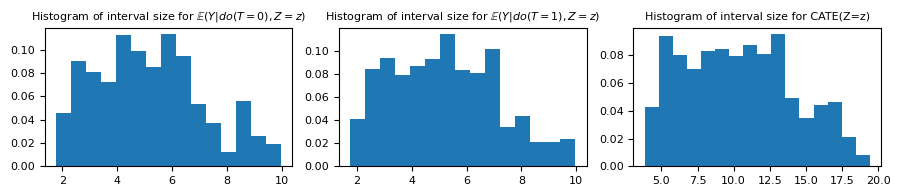

In [17]:
fig, ax = plt.subplots(ncols=3, figsize=(9, 2))
aux_hist = np.hstack([df_val.ic_size_t_0, df_val.ic_size_t_1])
min_hist, max_hist = np.min(aux_hist), np.max(aux_hist)
ax[0].hist(df_val.ic_size_t_0, bins=np.linspace(min_hist, max_hist, 16), weights=np.ones_like(df_val.ic_size_t_0)/df_val.shape[0])
ax[1].hist(df_val.ic_size_t_1, bins=np.linspace(min_hist, max_hist, 16), weights=np.ones_like(df_val.ic_size_t_1)/df_val.shape[0])
ax[2].hist(df_val_cate.cate_ci_size, bins=16, weights=np.ones_like(df_val_cate.cate_ci_size)/df_val_cate.shape[0])
ax[0].set_title("Histogram of interval size for $\mathbb{E}(Y | do(T=0), Z=z)$", fontsize="medium")
ax[1].set_title("Histogram of interval size for $\mathbb{E}(Y | do(T=1), Z=z)$", fontsize="medium")
ax[2].set_title("Histogram of interval size for CATE(Z=z)", fontsize="medium")
plt.tight_layout()

Mesmo nossos intervalos de predição individuais tendo sido construídos para $1 - \alpha = 0.9$, nosso intervalos de predição para o $\textrm{CATE}$ deveria ser de apenas $1 - (0.1 + 0.1) = 0.8$, mas como discutido anteriormente, ele é muito grosseiro e na verdade fica bem melhor que isso.

In [18]:
df_val_cate.coverage_cate.mean()

1.0

Como estamos num com $Z\in\mathbb{R}$, podemos avaliar visualmente nosso estimador conforme plotando os intervalos de predição para os meta estimadores e para a nossa estimativa do CATE. Além disso, aqui temos controle da variância do ruído e podemos plotar o intervalo de confiança 95% real. Vemos que, de fato, todas nossos intervalos de previsões parecem muito aderentes ao valor teórico.

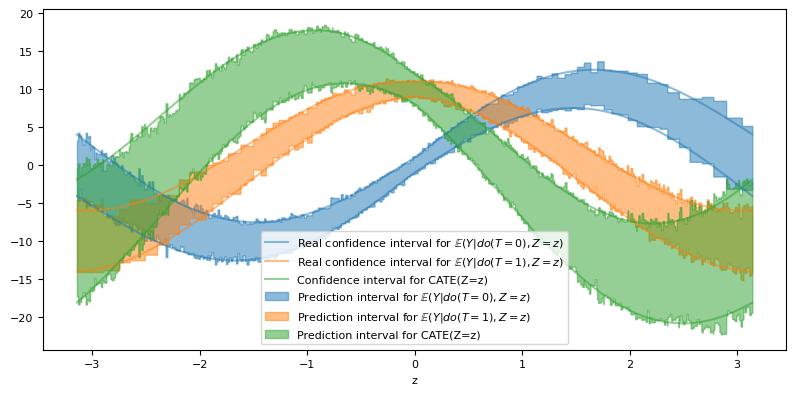

In [19]:
confouder_plot = np.linspace(XZ_test.confounder.min(), XZ_test.confounder.max(), 10_001)
ci_t1_plot = model_t1.predict(confouder_plot.reshape(-1, 1)).T
ci_t0_plot = model_t0.predict(confouder_plot.reshape(-1, 1)).T
ci_cate_plot = ci_t1_plot - ci_t0_plot[::-1,]

fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(confouder_plot, func_0(confouder_plot) +  1.96*(0.5 * (1 + np.abs(confouder_plot))), alpha=0.5, c="C0", label="Real confidence interval for $\mathbb{E}(Y | do(T=0), Z=z)$")
ax.plot(confouder_plot, func_0(confouder_plot) -  1.96*(0.5 * (1 + np.abs(confouder_plot))), alpha=0.5, c="C0")

ax.plot(confouder_plot, func_1(confouder_plot) +  1.96*(0.5 * (1 + np.abs(confouder_plot))), alpha=0.5, c="C1", label="Real confidence interval for $\mathbb{E}(Y | do(T=1), Z=z)$")
ax.plot(confouder_plot, func_1(confouder_plot) -  1.96*(0.5 * (1 + np.abs(confouder_plot))), alpha=0.5, c="C1")

ax.plot(confouder_plot, func_1(confouder_plot) - func_0(confouder_plot) + 2* 1.96*(0.5 * (1 + np.abs(confouder_plot))), alpha=0.5, c="C2", label="Confidence interval for CATE(Z=z)")
ax.plot(confouder_plot, func_1(confouder_plot) - func_0(confouder_plot) - 2* 1.96*(0.5 * (1 + np.abs(confouder_plot))), alpha=0.5, c="C2")

ax.fill_between(confouder_plot, *ci_t0_plot, alpha=0.5, label="Prediction interval for $\mathbb{E}(Y | do(T=0), Z=z)$", color="C0")
ax.fill_between(confouder_plot, *ci_t1_plot, alpha=0.5, label="Prediction interval for $\mathbb{E}(Y | do(T=1), Z=z)$", color="C1")
ax.fill_between(confouder_plot, *ci_cate_plot, alpha=0.5, label="Prediction interval for CATE(Z=z)", color="C2")

ax.set_xlabel("z")
ax.legend()
plt.tight_layout()

___

## Final considerations

O CATE é uma quantidade extremamente interessante de se ter em vários cenários de inferência causal aplicado. Ser capaz de traduzir as ideias de predição conforme para esse cenário é uma habilidade útil e importante para manter os ganhos que uncertainty quantification nos dá na tomada de decisão.

___

Referencias

1 - Playlist conformal

2 - Rafael Stern

3 - Facure

4 - Brandy Neal

5 - https://blog.dataiku.com/causal-inference-on-observational-data-its-all-about-the-assumptions

6 - https://scikit-learn.org/stable/modules/calibration.html

7 - https://arxiv.org/abs/1102.2101

8 - https://towardsdatascience.com/how-to-predict-risk-proportional-intervals-with-conformal-quantile-regression-175775840dc4

9 - https://arxiv.org/abs/1206.4650

10 - https://statisticaloddsandends.wordpress.com/2022/05/20/t-learners-s-learners-and-x-learners/

11 - https://en.wikipedia.org/wiki/Bonferroni_correction

___